In [ ]:
TASK -1

In [1]:
import cv2
import numpy as np

In [2]:
# Load video
video_path = "task1.mp4"  
cap = cv2.VideoCapture(video_path)

In [3]:
# Background subtractor for person detection
fgbg = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=True)

In [4]:
# Define a function for color histogram extraction
def calculate_histogram(frame, bbox):
    x, y, w, h = bbox
    roi = frame[y:y+h, x:x+w]
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
    cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)
    return hist

In [5]:
# Initialize variables for tracking
tracker_initialized = False
tracked_bbox = None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Apply background subtraction
    fgmask = fgbg.apply(frame)
    _, fgmask = cv2.threshold(fgmask, 200, 255, cv2.THRESH_BINARY)

    # Remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

    # Find contours
    contours, _ = cv2.findContours(fgmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Filter out small contours
        if cv2.contourArea(contour) < 1500:
            continue

        # Get bounding box
        x, y, w, h = cv2.boundingRect(contour)

        # Initialize tracking with the first detected person
        if not tracker_initialized:
            tracked_bbox = (x, y, w, h)
            tracker_initialized = True
            target_hist = calculate_histogram(frame, tracked_bbox)

        # Calculate histogram for current bounding box
        candidate_hist = calculate_histogram(frame, (x, y, w, h))
        similarity = cv2.compareHist(target_hist, candidate_hist, cv2.HISTCMP_CORREL)

        # If similarity is high, consider it the same person
        if similarity > 0.7:
            tracked_bbox = (x, y, w, h)

    # Draw the tracked bounding box
    if tracked_bbox:
        x, y, w, h = tracked_bbox
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, "Person", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow("Person Tracking", frame)

    # Break the loop on pressing 'q'
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
TASK - 2

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

In [7]:
# Load video
video_path = "TASK2.mp4"  
cap = cv2.VideoCapture(video_path)

In [8]:
# Background subtractor for motion detection
fgbg = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=True)

In [9]:
# Frame rate and duration
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
video_duration = total_frames / fps

In [10]:
# Parameters
time_interval = 10 * 60  # 10 minutes in seconds
frames_per_interval = fps * time_interval

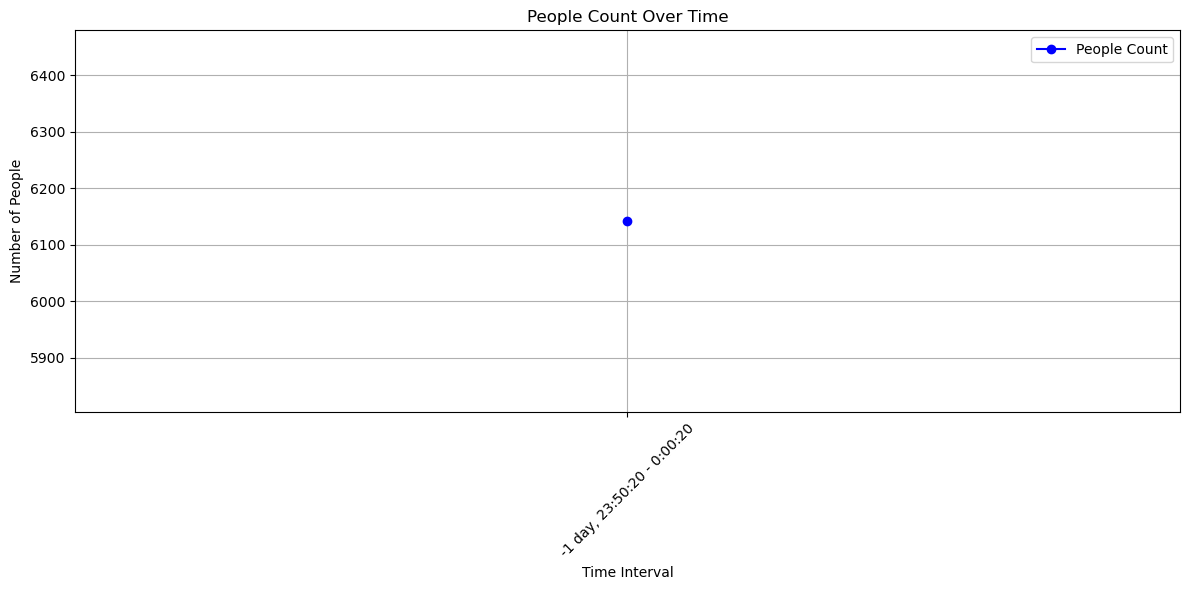

Peak Shopping Duration: -1 day, 23:50:20 - 0:00:20
Maximum Number of People: 6142


In [11]:
# Tracking people count
people_count = []
interval_times = []
current_count = 0
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1

    # Apply background subtraction
    fgmask = fgbg.apply(frame)
    _, fgmask = cv2.threshold(fgmask, 200, 255, cv2.THRESH_BINARY)

    # Remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

    # Find contours
    contours, _ = cv2.findContours(fgmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    person_count = 0

    for contour in contours:
        # Filter out small contours
        if cv2.contourArea(contour) < 1500:
            continue
        person_count += 1

    # Track the number of people in the current frame
    current_count += person_count

    # Store count at the end of each interval
    if frame_count % frames_per_interval == 0 or frame_count == total_frames:
        interval_start_time = timedelta(seconds=(frame_count - frames_per_interval) / fps)
        interval_end_time = timedelta(seconds=frame_count / fps)
        interval_times.append(f"{interval_start_time} - {interval_end_time}")
        people_count.append(current_count)
        current_count = 0

    # Display frame (optional for debugging)
    # cv2.imshow("Video", frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

cap.release()
cv2.destroyAllWindows()

# Find peak duration
peak_index = np.argmax(people_count)
peak_time = interval_times[peak_index]
peak_count = people_count[peak_index]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(interval_times, people_count, marker='o', linestyle='-', color='b', label="People Count")
plt.xticks(rotation=45)
plt.xlabel("Time Interval")
plt.ylabel("Number of People")
plt.title("People Count Over Time")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Summary of results
print(f"Peak Shopping Duration: {peak_time}")
print(f"Maximum Number of People: {peak_count}")

In [ ]:
TASK - 3

In [16]:
import cv2
import numpy as np

In [17]:
# Load the reference image
reference_image_path = "images.jpg"  
reference_image = cv2.imread(reference_image_path)

In [18]:
# Convert the reference image to grayscale
gray_ref = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)

In [19]:
# Load the Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [21]:
# Detect the face in the reference image
ref_faces = face_cascade.detectMultiScale(gray_ref, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

if len(ref_faces) == 0:
    print("No face detected in the reference image.")
    exit()

In [22]:
# Assume the first detected face is the suspect's face
x, y, w, h = ref_faces[0]
ref_face = gray_ref[y:y+h, x:x+w]

In [27]:
# Load the video
video_path = "task1.mp4" 
cap = cv2.VideoCapture(video_path)


In [28]:
# SIFT for feature extraction
sift = cv2.SIFT_create()
keypoints_ref, descriptors_ref = sift.detectAndCompute(ref_face, None)

In [29]:
# Match frames
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

In [30]:
# Initialize result storage
frame_count = 0
matching_frames = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1

    # Convert the current frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

    for (x, y, w, h) in faces:
        detected_face = gray_frame[y:y+h, x:x+w]

        # Extract features from the detected face
        keypoints_frame, descriptors_frame = sift.detectAndCompute(detected_face, None)

        if descriptors_frame is not None:
            # Match features
            matches = bf.match(descriptors_ref, descriptors_frame)
            matches = sorted(matches, key=lambda x: x.distance)

            # Calculate similarity
            similarity = np.mean([match.distance for match in matches[:10]])

            # Set a threshold for matching
            if similarity < 100:  # Adjust this threshold for sensitivity
                matching_frames.append(frame_count)
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2.putText(frame, "Match Found", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Display the frame (optional for debugging)
    cv2.imshow("Video", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Output results
if matching_frames:
    print(f"Match found in frames: {matching_frames}")
else:
    print("No match found.")

No match found.


In [ ]:
TASK - 4

In [31]:
import cv2
import numpy as np

In [32]:
# Load video
video_path = "TASK4.mp4" 
cap = cv2.VideoCapture(video_path)

In [33]:
# Initialize background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=True)

In [34]:
# Define ROI for entrance area
roi_top, roi_bottom = 200, 400  # Adjust these values based on the video frame
roi_left, roi_right = 300, 500

In [35]:
# Initialize counters
people_entered = 0
people_exited = 0


In [36]:
# Direction tracking
motion_history = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale and apply background subtraction
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    fgmask = fgbg.apply(gray_frame)

    # Define ROI mask
    roi_mask = np.zeros_like(fgmask)
    roi_mask[roi_top:roi_bottom, roi_left:roi_right] = 255
    fgmask = cv2.bitwise_and(fgmask, roi_mask)

    # Remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

    # Find contours
    contours, _ = cv2.findContours(fgmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Filter small contours
        if cv2.contourArea(contour) < 1500:
            continue

        # Get bounding box
        x, y, w, h = cv2.boundingRect(contour)
        cx, cy = x + w // 2, y + h // 2  # Calculate the centroid

        # Track motion history
        motion_history.append((cx, cy))

        # Determine direction
        if len(motion_history) > 2:
            prev_cx, prev_cy = motion_history[-2]
            if prev_cy < roi_top and cy > roi_top:  # Crossing into the shop
                people_entered += 1
            elif prev_cy > roi_bottom and cy < roi_bottom:  # Crossing out of the shop
                people_exited += 1

        # Draw bounding box and centroid
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.circle(frame, (cx, cy), 5, (0, 0, 255), -1)

    # Draw ROI on the frame
    cv2.rectangle(frame, (roi_left, roi_top), (roi_right, roi_bottom), (255, 0, 0), 2)

    # Display counters
    cv2.putText(frame, f"Entered: {people_entered}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Exited: {people_exited}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Show the frame
    cv2.imshow("Shop Entrance", frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Final result
print(f"Total People Entered: {people_entered}")
print(f"Total People Exited: {people_exited}")

Total People Entered: 0
Total People Exited: 0


In [ ]:
TASK - 5

In [48]:
import cv2
import numpy as np
from collections import defaultdict
import time

# Load the video
video_path = "TASK5.mp4"  
cap = cv2.VideoCapture(video_path)

# Background subtractor for motion detection
fgbg = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=True)

# Define Region of Interest (ROI)
roi_top, roi_bottom = 200, 400  # Adjust based on the video
roi_left, roi_right = 300, 500

# Initialize variables
dwelling_times = defaultdict(float)
entry_timestamps = {}
exit_timestamps = {}
object_id_counter = 0
tracked_objects = {}

fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Apply background subtraction
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    fgmask = fgbg.apply(gray_frame)

    # Define ROI mask
    roi_mask = np.zeros_like(fgmask)
    roi_mask[roi_top:roi_bottom, roi_left:roi_right] = 255
    fgmask = cv2.bitwise_and(fgmask, roi_mask)

    # Remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

    # Find contours
    contours, _ = cv2.findContours(fgmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    current_frame_objects = []

    for contour in contours:
        # Filter out small contours
        if cv2.contourArea(contour) < 1500:
            continue

        # Get bounding box
        x, y, w, h = cv2.boundingRect(contour)
        cx, cy = x + w // 2, y + h // 2  # Centroid

        if roi_left < cx < roi_right and roi_top < cy < roi_bottom:
            # Check if the object is already being tracked
            found = False
            for obj_id, (px, py) in tracked_objects.items():
                if abs(cx - px) < 20 and abs(cy - py) < 20:  # Proximity check
                    tracked_objects[obj_id] = (cx, cy)
                    current_frame_objects.append(obj_id)
                    found = True
                    break

            # If not found, assign a new ID
            if not found:
                object_id_counter += 1
                tracked_objects[object_id_counter] = (cx, cy)
                current_frame_objects.append(object_id_counter)
                entry_timestamps[object_id_counter] = time.time()

    # Check for objects that left the ROI
    for obj_id in list(tracked_objects.keys()):
        if obj_id not in current_frame_objects:
            exit_timestamps[obj_id] = time.time()
            tracked_objects.pop(obj_id)

    # Update dwelling times
    for obj_id in current_frame_objects:
        if obj_id in entry_timestamps:
            dwelling_times[obj_id] = time.time() - entry_timestamps[obj_id]

    # Visualize the ROI and tracked objects
    cv2.rectangle(frame, (roi_left, roi_top), (roi_right, roi_bottom), (255, 0, 0), 2)
    for obj_id, (cx, cy) in tracked_objects.items():
        cv2.circle(frame, (cx, cy), 5, (0, 255, 0), -1)
        cv2.putText(frame, f"ID: {obj_id}", (cx + 10, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display current frame
    cv2.imshow("Dwelling Time", frame)
    if cv2.waitKey(30) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

# Final dwelling time report
print("Dwelling Times (in seconds):")
for obj_id, time_spent in dwelling_times.items():
    print(f"Object {obj_id}: {time_spent:.2f} seconds")

Dwelling Times (in seconds):
Object 1: 0.00 seconds
Object 2: 0.16 seconds
Object 3: 0.00 seconds
Object 4: 0.80 seconds
Object 5: 0.00 seconds
Object 6: 0.26 seconds
Object 7: 0.00 seconds
Object 8: 0.52 seconds


In [ ]:
TASK - 6

In [49]:
import cv2
import numpy as np

In [50]:
# Load video
video_path = "TAK6.mp4"
cap = cv2.VideoCapture(video_path)

In [52]:
# Load the branded car template (e.g., logo or reference image of the car)
template_path = "CARR.jpg"  # Replace with the path to your template
template = cv2.imread(template_path, 0)
template_h, template_w = template.shape

In [53]:
# Create a background subtractor for motion detection
fgbg = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=True)

In [54]:
# Variables to track branded car appearances
branded_car_count = 0
frames_with_branded_car = []

frame_number = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_number += 1
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect motion using background subtraction
    fgmask = fgbg.apply(gray_frame)

    # Remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

    # Find contours
    contours, _ = cv2.findContours(fgmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Filter out small contours
        if cv2.contourArea(contour) < 2000:
            continue

        # Get bounding box for the detected car
        x, y, w, h = cv2.boundingRect(contour)
        car_roi = gray_frame[y:y+h, x:x+w]

        # Resize the detected car ROI to match the template size for comparison
        resized_car = cv2.resize(car_roi, (template_w, template_h), interpolation=cv2.INTER_AREA)

        # Perform template matching
        result = cv2.matchTemplate(resized_car, template, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

        # Threshold to identify a match
        if max_val > 0.7:  # Adjust threshold as needed
            branded_car_count += 1
            frames_with_branded_car.append(frame_number)

            # Draw bounding box on the original frame
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, "Branded Car Detected", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow("Branded Car Detection", frame)
    if cv2.waitKey(30) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

# Output results
print(f"Total branded cars detected: {branded_car_count}")
print(f"Frames with branded car detected: {frames_with_branded_car}")

Total branded cars detected: 0
Frames with branded car detected: []
